In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#
df = pd.read_csv("news.csv")

X = df[['title', 'text']]
y = df['label']


# Splitting the dataset into training and testing sets
# X: Features (independent variables) of the dataset
# y: Target variable (dependent variable) of the dataset
# test_size: Proportion of the dataset to include in the testing split (here, 20%)
# random_state: Seed used by the random number generator for reproducibility
# stratify: Ensures that the target variable's class distribution is preserved in the splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Maximum number of words to keep, based on word frequency. Only the most common num_words words will be kept.
max_words = 10000

# Maximum length of sequences. Sequences longer than this will be truncated, and sequences shorter than this will be padded.
max_len = 200

# Tokenizer object for converting text data into sequences of integers
tokenizer = Tokenizer(num_words=max_words)

# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(X_train['text'])

# Converts a list of texts into sequences of integers.
X_train_seq = tokenizer.texts_to_sequences(X_train['text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['text'])

max_words: Maximum number of words to consider, based on frequency

max_len: Maximum length of sequences

tokenizer: Tokenizer object initialized with num_words as the maximum number of words to keep

tokenizer.fit_on_texts(): Updates the internal vocabulary based on the text data in the training set

tokenizer.texts_to_sequences(): Converts the text data in the training and testing sets into sequences of integers based on the vocabulary learned from the training data

X_train_seq: Sequences of integers representing the text data in the training set

X_test_seq: Sequences of integers representing the text data in the testing set

In [7]:
# Padding sequences to ensure uniform length
# X_train_seq: Sequences of integers representing the text data in the training set
# X_test_seq: Sequences of integers representing the text data in the testing set
# maxlen: Maximum length of sequences (previously defined as 200)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [8]:
# Label encoding for target variables
# label_encoder: LabelEncoder object for encoding categorical labels into numerical values
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels for y_train
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform labels in y_test to numerical values using the fitted label encoder
y_test_encoded = label_encoder.transform(y_test)


In [9]:
# Creating a Sequential model
model = Sequential()

# Adding an Embedding layer
# input_dim: Size of the vocabulary (previously defined as max_words)
# output_dim: Dimension of the dense embedding
# input_length: Length of input sequences (previously defined as max_len)
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))

# Adding a Flatten layer to convert the 3D embedding output into 2D
model.add(Flatten())

# Adding a Dense layer with 128 units and ReLU activation function
model.add(Dense(128, activation='relu'))

# Adding a Dropout layer to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training
model.add(Dropout(0.5))  # 50% dropout rate

# Adding the output layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
# optimizer: Adam optimizer for gradient descent optimization
# loss: Binary crossentropy loss function for binary classification
# metrics: List of metrics to be evaluated during training and testing, here using accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In summary:

The model consists of an Embedding layer, a Flatten layer, two Dense layers, and a Dropout layer.

The Embedding layer converts input text sequences into dense vectors of fixed size.

The Flatten layer reshapes the 3D embedding output into 2D.

The first Dense layer has 128 units with ReLU activation.

Dropout layer is added to prevent overfitting by randomly dropping a fraction of input units.

The output layer has 1 unit with a sigmoid activation function for binary classification.

The model is compiled using the Adam optimizer, binary crossentropy loss function, and accuracy as the evaluation metric.

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 flatten_2 (Flatten)         (None, 25600)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3276928   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4557057 (17.38 MB)
Trainable params: 4557057 (17.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Training the model
# X_train_pad: Padded sequences of training data
# y_train_encoded: Encoded numerical labels for the training data
# epochs: Number of epochs (iterations over the entire training dataset)
# batch_size: Number of samples per gradient update
# validation_split: Fraction of the training data to be used as validation data
history = model.fit(X_train_pad, y_train_encoded, epochs=50, batch_size=64, validation_split=0.2)


Epoch 1/5
64/64 [==============================] - 4s 43ms/step - loss: 0.5698 - accuracy: 0.7015 - val_loss: 0.3904 - val_accuracy: 0.8304
Epoch 2/5
64/64 [==============================] - 3s 41ms/step - loss: 0.0982 - accuracy: 0.9655 - val_loss: 0.3027 - val_accuracy: 0.8669
Epoch 3/5
64/64 [==============================] - 3s 43ms/step - loss: 0.0182 - accuracy: 0.9956 - val_loss: 0.3037 - val_accuracy: 0.8669
Epoch 4/5
64/64 [==============================] - 3s 41ms/step - loss: 0.0048 - accuracy: 0.9995 - val_loss: 0.3036 - val_accuracy: 0.8767
Epoch 5/5
64/64 [==============================] - 3s 41ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.3109 - val_accuracy: 0.8738


In [12]:
# Predicting probabilities for the test data
y_pred_prob = model.predict(X_test_pad)

# Converting probabilities to binary predictions using a threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculating accuracy score
accuracy = accuracy_score(y_test_encoded, y_pred)


print(f"Accuracy: {accuracy:.2f}")


print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred))


print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))

# Creating a DataFrame to display actual vs predicted values
results_df = pd.DataFrame({'Actual': y_test_encoded, 'Predicted': y_pred.flatten()})
print("\nActual vs Predicted Values:\n", results_df)


40/40 [==============================] - 0s 6ms/step
Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       633
           1       0.88      0.88      0.88       634

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267


Confusion Matrix:
 [[553  80]
 [ 74 560]]

Actual vs Predicted Values:
       Actual  Predicted
0          1          1
1          0          0
2          1          0
3          0          0
4          1          1
...      ...        ...
1262       1          1
1263       1          1
1264       1          1
1265       0          0
1266       1          1

[1267 rows x 2 columns]


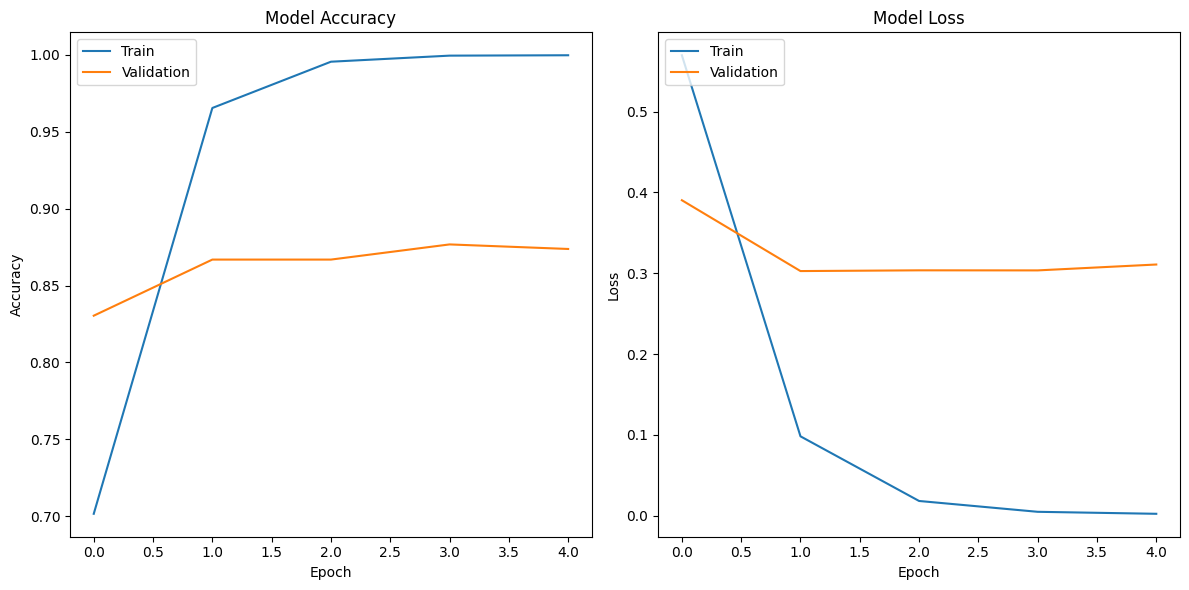

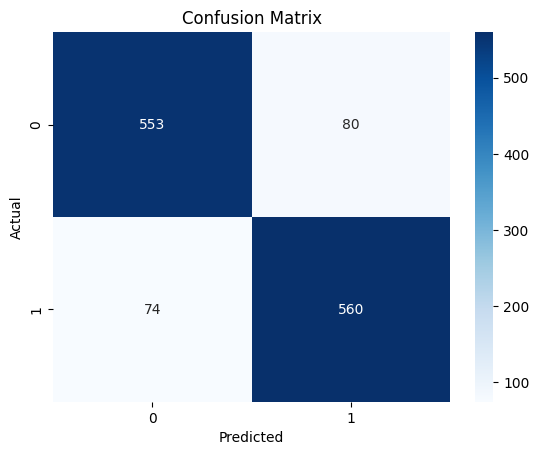

In [13]:
def plot_history(history):
    # Setting up the figure size
    plt.figure(figsize=(12, 6))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Adjusting layout to avoid overlap
    plt.tight_layout()

    # Displaying the plot
    plt.show()

# Plotting the training and validation accuracy/loss
plot_history(history)

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
